# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

Carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization

In [1]:
# Loading all the libraries
import pandas
import pandas as pd
import numpy as np
import math as mt
import seaborn as sns
from matplotlib import pyplot as plt
from math import factorial
from scipy import stats as st
from functools import reduce

## Load data

In [12]:
# Load the data files into different DataFrames
def file_path(x):
    y = pd.read_csv(x)
    return y

In [13]:
df_users = file_path(r"C:\Users\kevin\datasets\megaline_users.csv")
df_calls = file_path(r"C:\Users\kevin\datasets\megaline_calls.csv")
df_messages = file_path(r"C:\Users\kevin\datasets\megaline_messages.csv")
df_internet = file_path(r"C:\Users\kevin\datasets\megaline_internet.csv")
df_plans = file_path(r"C:\Users\kevin\datasets\megaline_plans.csv")

## Prepare the data

## Plans

In [15]:
# Print the general/summary information about the plans' DataFrame
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


The plan dataframe shows each name of the plan provided. The dataframe provides basic information on each plan.
This includes cost per month, monthly minutes, monthly text data volume, price per minute.

In [16]:
# Print a sample of data for plans
df_plans.sample(2)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
1,1000,30720,3000,70,7,0.01,0.01,ultimate
0,50,15360,500,20,10,0.03,0.03,surf


## Fix data

In [17]:
df_plans.drop(['mb_per_month_included'], axis=1, inplace= True)

## Enrich data

In [18]:
df_plans.insert(1,'gb_per_month_included',['15','30'],True)
df_plans.rename(columns = {'gb_per_month_included':'GB_per_month','minutes_included':'monthly_minutes'}, inplace=True)
df_plans['plan_name'].astype(str)
df_plans.head()

,messages_included,GB_per_month,monthly_minutes,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


## Users

In [21]:
# Print the general/summary information about the users' DataFrame
# This dataframe shares user-data and what plan each user is signed up to
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [22]:
# Print a sample of data for users
df_users.sample(25)
#data types are all correct, but we need to re-name some columns for a better idea of the column and fill in missing values


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
377,1377,Vallie,Conway,18,"Rochester, NY MSA",2018-03-27,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
412,1412,Cortez,Reese,61,"Detroit-Warren-Dearborn, MI MSA",2018-04-08,ultimate,NaN
275,1275,Elvie,Velazquez,33,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-29,ultimate,NaN
75,1075,Salena,Bates,35,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-08-06,surf,NaN
49,1049,Loise,Avery,25,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-21,surf,NaN
418,1418,Hal,Barnes,40,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-19,surf,NaN
406,1406,Noble,Jefferson,54,"San Diego-Chula Vista-Carlsbad, CA MSA",2018-03-04,surf,NaN
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07
416,1416,Deja,Moss,25,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",2018-10-03,surf,2018-11-21


### Fix Data

In [23]:
df_users.fillna('', inplace=True)

### Enrich Data

In [24]:
df_users.rename(columns ={'reg_date':'subscription_date','churn_date':'canceled_date'}, inplace=True)
df_users.head(15)

,user_id,first_name,last_name,age,city,subscription_date,plan,canceled_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,


## Calls

In [25]:
# Print the general/summary information about the calls' DataFrame
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [12]:
# Print a sample of data for calls
df_calls.sample(25)

,id,user_id,call_date,duration
36307,1138_261,1138,2018-11-07,11.62
104531,1368_229,1368,2018-12-10,7.14
132935,1479_428,1479,2018-12-15,15.25
114993,1403_67,1403,2018-10-21,20.13
119671,1417_231,1417,2018-08-22,0.30
215,1001_394,1001,2018-11-28,7.41
102876,1365_72,1365,2018-10-19,8.72
50037,1181_319,1181,2018-09-18,9.86
64049,1232_326,1232,2018-10-01,0.02
135,1001_232,1001,2018-12-20,1.00


Each column has the right Data Type and no missing values, 
There are duplicated user_id columns, but this does not need to be dropped. A user can make multiple calls if they wanted to
not just one

### Fix data

[Fix obvious issues with the data given the initial observations.]

In [26]:
#No fixing needed. Duplicate values are fine for particular user_id column and no missing values. 
df_calls['duration']= df_calls['duration'].apply(np.ceil)
print(df_calls['duration'])

0          9.0
1         14.0
2         15.0
3          6.0
4          5.0
          ... 
137730     9.0
137731    11.0
137732     9.0
137733     1.0
137734    14.0
Name: duration, Length: 137735, dtype: float64


### Enrich data

In [27]:
df_calls.rename(columns= {'duration':'duration_in_minutes'},inplace=True)
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_calls.sample(20)

,id,user_id,call_date,duration_in_minutes,month
63964,1232_219,1232,2018-05-02,16.0,5
52384,1187_577,1187,2018-04-15,16.0,4
135197,1490_297,1490,2018-09-01,20.0,9
47411,1172_2,1172,2018-10-18,0.0,10
50264,1181_623,1181,2018-08-27,6.0,8
44947,1163_6,1163,2018-10-12,18.0,10
14409,1059_645,1059,2018-07-21,13.0,7
93501,1334_869,1334,2018-06-22,8.0,6
13827,1059_44,1059,2018-05-04,3.0,5
122531,1433_102,1433,2018-09-29,3.0,9


## Messages

In [28]:
# Print the general/summary information about the messages' DataFrame
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [29]:
# Print a sample of data for messages
df_messages.sample(20)

,id,user_id,message_date
32254,1199_520,1199,2018-11-10
20568,1130_243,1130,2018-12-16
15474,1101_531,1101,2018-04-27
48952,1327_45,1327,2018-09-05
70246,1456_180,1456,2018-07-16
35803,1236_72,1236,2018-07-11
18690,1121_17,1121,2018-12-04
60772,1382_486,1382,2018-11-17
32097,1199_273,1199,2018-08-04
41350,1264_573,1264,2018-07-19


### Fix data

In [30]:
df_messages.duplicated().sum()
df_messages.isna().sum()
#check for duplicates and missing values there were none

id              0
user_id         0
message_date    0
dtype: int64

### Enrich data

In [31]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month

## Internet

In [32]:
# Print the general/summary information about the internet DataFrame
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [33]:
# Print a sample of data for the internet traffic
df_internet.sample(20)

,id,user_id,session_date,mb_used
4627,1028_184,1028,2018-07-31,364.57
97982,1461_142,1461,2018-12-03,330.66
70593,1329_301,1329,2018-09-26,202.33
4015,1022_426,1022,2018-12-21,0.00
4995,1028_570,1028,2018-10-08,978.24
81715,1383_166,1383,2018-10-16,550.01
12567,1061_64,1061,2018-07-30,454.09
49716,1222_215,1222,2018-10-09,311.76
8671,1045_354,1045,2018-11-19,34.23
102205,1490_20,1490,2018-09-30,494.53


### Fix data

In [34]:
df_internet['mb_used'] = df_internet['mb_used']/1024


### Enrich data

In [35]:
df_internet.rename(columns= {'mb_used':'gb_used'},inplace=True)
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_internet.head(20)

,id,user_id,session_date,gb_used,month
0,1000_13,1000,2018-12-29,0.087754,12
1,1000_204,1000,2018-12-31,0.000000,12
2,1000_379,1000,2018-12-28,0.644922,12
3,1000_413,1000,2018-12-26,0.264639,12
4,1000_442,1000,2018-12-27,0.859590,12
5,1001_0,1001,2018-08-24,0.278008,8
6,1001_3,1001,2018-12-09,0.640664,12
7,1001_4,1001,2018-11-04,0.016572,11
8,1001_10,1001,2018-11-27,0.132012,11
9,1001_15,1001,2018-12-13,0.744062,12


## Study plan conditions

In [36]:
# Print out the plan conditions and make sure they are clear for you
df_plans

,messages_included,GB_per_month,monthly_minutes,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0.03,0.03,surf
1,1000,30,3000,70,7,0.01,0.01,ultimate


In [37]:
# Calculate the number of calls made by each user per month. Save the result.
per_month_calls = df_calls.groupby(['user_id', 'month'])['id'].count()
df_total_calls = pd.DataFrame({'per_month_calls':per_month_calls}).reset_index()
display(df_total_calls)

,user_id,month,per_month_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


In [38]:
minutes_per_month = df_calls.groupby(['user_id','month'])['duration_in_minutes'].sum()
df_total_minutes = pd.DataFrame({'minutes_per_month':minutes_per_month}).reset_index()
display(df_total_minutes)

,user_id,month,minutes_per_month
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


In [39]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_per_month = df_messages.groupby(['user_id', 'month'])['id'].count()
df_total_messages = pd.DataFrame({'messages_per_month':messages_per_month}).reset_index()
display(df_total_messages)

,user_id,month,messages_per_month
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [40]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

traffic_per_month = df_internet.groupby(['user_id','month'])['gb_used'].sum().apply(np.ceil)
df_total_traffic= pd.DataFrame({'traffic_per_month': traffic_per_month}).reset_index()
display(df_total_traffic)



,user_id,month,traffic_per_month
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0
...,...,...,...
2272,1498,12,23.0
2273,1499,9,13.0
2274,1499,10,20.0
2275,1499,11,17.0


In [41]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
data_frames = [df_total_calls,df_total_minutes,df_total_messages,df_total_traffic]
per_month_df = reduce(lambda left,right: pd.merge(left,right,on=['month','user_id'],
                                            how='outer'), data_frames).fillna(0)
per_month_df.head(25)



,user_id,month,per_month_calls,minutes_per_month,messages_per_month,traffic_per_month
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,27.0,182.0,30.0,7.0
2,1001,9,49.0,315.0,44.0,14.0
3,1001,10,65.0,393.0,53.0,22.0
4,1001,11,64.0,426.0,36.0,19.0
5,1001,12,56.0,412.0,44.0,19.0
6,1002,10,11.0,59.0,15.0,7.0
7,1002,11,55.0,386.0,32.0,19.0
8,1002,12,47.0,384.0,41.0,15.0
9,1003,12,149.0,1104.0,50.0,27.0


In [42]:
# Add the plan information
df_user_plan = df_users[['user_id','plan','city']]
df_plan_information = per_month_df.merge(df_user_plan, on='user_id')
df_plan_information 

,user_id,month,per_month_calls,minutes_per_month,messages_per_month,traffic_per_month,plan,city
0,1000,12,16.0,124.0,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,27.0,182.0,30.0,7.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,49.0,315.0,44.0,14.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,65.0,393.0,53.0,22.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,64.0,426.0,36.0,19.0,surf,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...
2288,1204,12,0.0,0.0,78.0,36.0,ultimate,"Chicago-Naperville-Elgin, IL-IN-WI MSA"
2289,1349,10,0.0,0.0,76.0,13.0,surf,"Boston-Cambridge-Newton, MA-NH MSA"
2290,1349,11,0.0,0.0,72.0,17.0,surf,"Boston-Cambridge-Newton, MA-NH MSA"
2291,1349,12,0.0,0.0,61.0,13.0,surf,"Boston-Cambridge-Newton, MA-NH MSA"


In [43]:
# Calculate the monthly revenue for each user
def rev_calc(row):
    if row['plan'] == 'surf':
        revenue = 20 
        if row['minutes_per_month'] > 500:
            revenue += (row['minutes_per_month'] - 500) * .03
        if row['messages_per_month'] > 50: 
            revenue += (row['messages_per_month']-50) * .03
        if row['traffic_per_month'] > 15:
            revenue += (row['traffic_per_month']-15) * 10
    else:
        revenue = 70
        
        if row['minutes_per_month'] > 3000:
            revenue += (row['minutes_per_month'] - 3000) * .01
        if row['messages_per_month'] > 1000: 
            revenue += (row['messages_per_month']-1000) * .01
        if row['traffic_per_month'] > 30:
            revenue += (row['traffic_per_month']-30) * 7
    return revenue

df_plan_information['revenue'] = df_plan_information.apply(rev_calc, axis=1)


                
        
    


In [44]:
df_plan_information

,user_id,month,per_month_calls,minutes_per_month,messages_per_month,traffic_per_month,plan,city,revenue
0,1000,12,16.0,124.0,11.0,2.0,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",70.00
1,1001,8,27.0,182.0,30.0,7.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
2,1001,9,49.0,315.0,44.0,14.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",20.00
3,1001,10,65.0,393.0,53.0,22.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",90.09
4,1001,11,64.0,426.0,36.0,19.0,surf,"Seattle-Tacoma-Bellevue, WA MSA",60.00
...,...,...,...,...,...,...,...,...,...
2288,1204,12,0.0,0.0,78.0,36.0,ultimate,"Chicago-Naperville-Elgin, IL-IN-WI MSA",112.00
2289,1349,10,0.0,0.0,76.0,13.0,surf,"Boston-Cambridge-Newton, MA-NH MSA",20.78
2290,1349,11,0.0,0.0,72.0,17.0,surf,"Boston-Cambridge-Newton, MA-NH MSA",40.66
2291,1349,12,0.0,0.0,61.0,13.0,surf,"Boston-Cambridge-Newton, MA-NH MSA",20.33


## Study user behaviour

### Calls

In [45]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
# we need duration, plan, and month
# AVERGAE duration of calls(minutes), on each plan on each month.
aggregate_data = df_plan_information.groupby(['month','plan'])['minutes_per_month'].mean().reset_index()
aggregate_data.head(25)



,month,plan,minutes_per_month
0,1,surf,203.000000
1,1,ultimate,193.500000
2,2,surf,297.000000
3,2,ultimate,403.142857
4,3,surf,330.000000
5,3,ultimate,304.250000
6,4,surf,351.540000
7,4,ultimate,336.857143
8,5,surf,399.584416
9,5,ultimate,406.241379


Text(0.5, 1.0, 'Each Plans Amount of User Minutes Per Month')

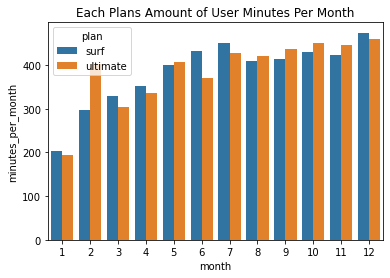

In [62]:
sns.barplot(data=aggregate_data, 
             x='month',
             y='minutes_per_month',
            hue = 'plan'
           )

plt.title('Each Plans Amount of User Minutes Per Month')

,user_id,plan,minutes_per_month
0,1000,ultimate,124.0
1,1001,surf,1728.0
2,1002,surf,829.0
3,1003,surf,1104.0
4,1004,surf,2772.0
...,...,...,...
485,1495,surf,1765.0
486,1496,surf,1455.0
487,1497,ultimate,300.0
488,1498,surf,3211.0


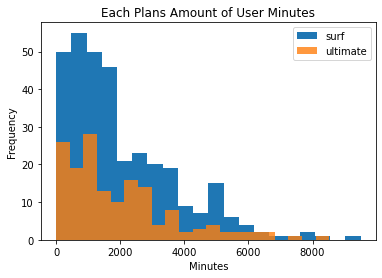

In [64]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.
# User, Minutes, and Plan. 
#Each month
# We need the minutes_per_month/plan for each user_id. 

compare_minutes_month = df_plan_information.groupby(['user_id','plan'])['minutes_per_month'].sum().reset_index()
display(compare_minutes_month)
compare_minutes_month[compare_minutes_month['plan'] == 'surf']['minutes_per_month'].plot(kind='hist', bins=20)
# Include an alpha value so we can fully see both histograms
compare_minutes_month[compare_minutes_month['plan'] == 'ultimate']['minutes_per_month'].plot(kind='hist', bins=20, alpha=0.8)
plt.legend(['surf', 'ultimate'])
plt.title('Each Plans Amount of User Minutes')
plt.xlabel('Minutes')
plt.show()

[Calculate the mean and the variable of the call duration to reason on whether users on the different plans have different behaviours for their calls.]

In [48]:
# Calculate the mean and the variance of the monthly call duration
df_plans_minutes_mean = df_plan_information.groupby(['plan','month'])['minutes_per_month'].mean().reset_index()
display(df_plans_minutes_mean)
df_plans_minutes_variance = df_plan_information.groupby(['plan','month'])['minutes_per_month'].var().reset_index()
display(df_plans_minutes_variance)

#Have pretty similar means and variances

,plan,month,minutes_per_month
0,surf,1,203.000000
1,surf,2,297.000000
2,surf,3,330.000000
3,surf,4,351.540000
4,surf,5,399.584416
5,surf,6,431.298969
6,surf,7,449.983471
7,surf,8,410.111111
8,surf,9,414.226804
9,surf,10,429.729958


,plan,month,minutes_per_month
0,surf,1,15842.000000
1,surf,2,52226.500000
2,surf,3,35809.363636
3,surf,4,50866.743265
4,surf,5,59754.219754
5,surf,6,45592.628436
6,surf,7,61005.099725
7,surf,8,54344.645963
8,surf,9,46595.958656
9,surf,10,52278.664056


,user_id,month,minutes_per_month
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2288,1498,12,339.0
2289,1499,9,346.0
2290,1499,10,385.0
2291,1499,11,308.0


Text(0.5, 1.0, 'Monthly Call Duration')

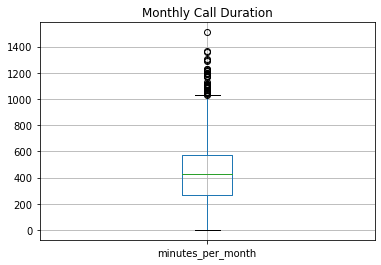

In [65]:
merged_monthly_call_plan = df_plan_information.groupby(['user_id','month'])['minutes_per_month'].sum().reset_index()
display(merged_monthly_call_plan)
merged_monthly_call_plan.boxplot(column='minutes_per_month')

plt.title('Monthly Call Duration')

The main conclusion of these duration of calls is users who use the "surf" plan use their calling plan more compared to "ultimate" plan 

### Messages

In [50]:
# Compare the number of messages users of each plan tend to send each month
messages_per_month_plan = df_plan_information.groupby(['plan','month'])['messages_per_month'].sum().reset_index()
messages_per_month_plan

,plan,month,messages_per_month
0,surf,1,21.0
1,surf,2,108.0
2,surf,3,351.0
3,surf,4,870.0
4,surf,5,1849.0
5,surf,6,2454.0
6,surf,7,3271.0
7,surf,8,4662.0
8,surf,9,5968.0
9,surf,10,8020.0


In [51]:
# Compare the amount of internet traffic consumed by users per plan
print(df_plan_information.groupby('plan')['traffic_per_month'].sum().reset_index())
print(df_plan_information.groupby('user_id')['traffic_per_month'].sum().reset_index())

       plan  traffic_per_month
0      surf            26223.0
1  ultimate            12461.0
     user_id  traffic_per_month
0       1000                2.0
1       1001               81.0
2       1002               41.0
3       1003               27.0
4       1004              157.0
..       ...                ...
485     1495               99.0
486     1496               66.0
487     1497               11.0
488     1498              228.0
489     1499               72.0

[490 rows x 2 columns]


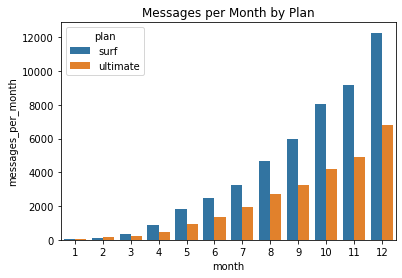

In [55]:
sns.barplot(data=messages_per_month_plan, 
             x='month',
             y='messages_per_month', 
            hue = 'plan' 
           )
plt.title('Messages per Month by Plan')

# Show the plot
plt.show()

Surf has way more messages per month compared to ultimate

### Internet

In [56]:
internet_traffic_per_plan_month = df_plan_information.groupby(['month','plan'])['traffic_per_month'].sum().reset_index()
internet_traffic_per_plan_month

,month,plan,traffic_per_month
0,1,surf,10.0
1,1,ultimate,29.0
2,2,surf,110.0
3,2,ultimate,121.0
4,3,surf,312.0
5,3,ultimate,221.0
6,4,surf,611.0
7,4,ultimate,343.0
8,5,surf,1087.0
9,5,ultimate,489.0


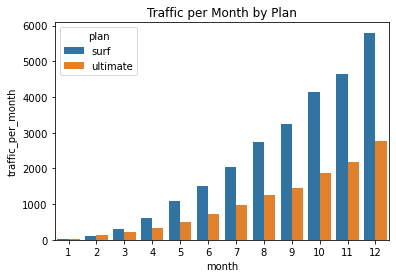

In [58]:
sns.barplot(data=internet_traffic_per_plan_month, 
             x='month',
             y='traffic_per_month', 
            hue = 'plan' 
           )

plt.title('Traffic per Month by Plan')

# Show the plot
plt.show()

Surf has more traffic per month 

In [59]:
m_int = internet_traffic_per_plan_month['traffic_per_month'].mean()
var_int = internet_traffic_per_plan_month['traffic_per_month'].var()
print(m_int)
print(var_int)



1611.8333333333333
2504297.1884057974


Both plans increase over time, but surf seems to have a larger amiunt of client usage compared to ultimate. 

## Revenue

In [60]:
revenue_per_plan_month = df_plan_information.groupby(['plan', 'month'])['revenue'].sum().reset_index()
display(revenue_per_plan_month)

ultimate_plan = df_plan_information.query("plan == 'ultimate'")
surf_plan = df_plan_information.query("plan =='surf'")



,plan,month,revenue
0,surf,1,40.00
1,surf,2,309.57
2,surf,3,1056.65
3,surf,4,2035.53
4,surf,5,3667.37
5,surf,6,4779.80
6,surf,7,7583.56
7,surf,8,10356.85
8,surf,9,11304.67
9,surf,10,15504.83


<AxesSubplot:xlabel='month', ylabel='revenue'>

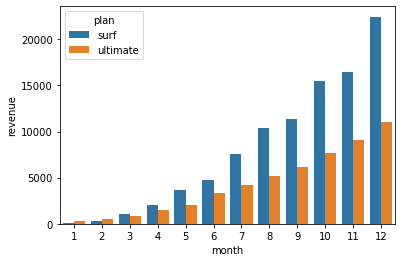

In [61]:
sns.barplot(data=revenue_per_plan_month , #dataset
             x='month', #variable along the x-axis
             y='revenue', #variable along the y-axis (usually the thing you are actually measuring)
            hue = 'plan' #the variable you want to group data by to compare (ex. gender, country, plan)
           )

# Surf has more revenue per month 

In [46]:
m_rev = revenue_per_plan_month['revenue'].mean()
var_rev = revenue_per_plan_month['revenue'].var()
print(m_int)
print(var_int)


#Surf is once again ahead of the curve. They have more revenue than ultimate. 

1611.8333333333333
2504297.188405797


## Test statistical hypotheses

In [47]:
# h0 = The null hypotheses is that the ultimate and surf calling plans generate the same amount of revenue for Megaline. 
# h1 = The alternative hypothesis is that the ultimate and surf calling plans DONT' generate the same amount of revenue for Megaline.

# Test the hypotheses
ultimate_rev = ultimate_plan.groupby('user_id')['revenue'].mean()
surf_rev = surf_plan.groupby('user_id')['revenue'].mean()
alpha = 0.05

results = st.ttest_ind(ultimate_rev, surf_rev)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis. The two groups have a difference that is unlikely due to random chance with a pvalue")
else:
    print("We cannot reject the null hypothesis due to a p value of the groups appear similar.")

p-value: 0.00011355294752235661
We reject the null hypothesis. The two groups have a difference that is unlikely due to random chance with a pvalue


In [48]:
# Test the hypotheses

nynj = df_plan_information[df_plan_information['city'].str.contains('NJ', 'NY')==True]
not_nynj = df_plan_information[~df_plan_information['city'].str.contains('NJ', 'NY')==True]

nynj_rev = nynj.groupby('user_id')['revenue'].mean()
not_nynj_rev = not_nynj.groupby('user_id')['revenue'].mean()


alpha = 0.05

results = st.ttest_ind(nynj_rev, not_nynj_rev)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis. The two groups have a difference that is unlikely due to random chance with a pvalue")
else:
    print("We cannot reject the null hypothesis due to a p value of the groups appear similar.")
    
# h0 = There is no difference in monthly revenue between NJ/NY Megaline users and users from the rest of the country.
# h1 = There is a difference in revenue between between NJ/NY Megaline users and users from the rest of the country.





p-value: 0.3822374104879729
We cannot reject the null hypothesis due to a p value of the groups appear similar.


In [49]:
df_plan_information.groupby('plan').count()

#These are the total count per user for each plan 

,user_id,month,per_month_calls,minutes_per_month,messages_per_month,traffic_per_month,city,revenue
plan,,,,,,,,
surf,1573,1573,1573,1573,1573,1573,1573,1573
ultimate,720,720,720,720,720,720,720,720


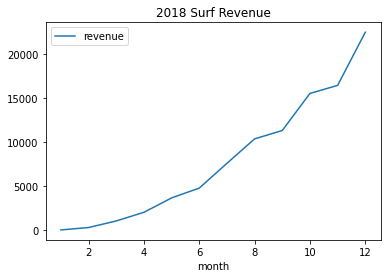

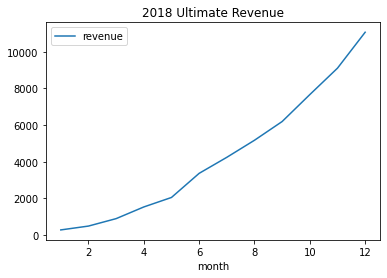

In [50]:
plan_counts= df_plan_information.groupby(['plan', 'month'])['revenue'].sum().reset_index()
plan_counts

#revenue per month for each plan 

surf = plan_counts[plan_counts['plan'] == 'surf']
ultimate = plan_counts[plan_counts['plan'] == 'ultimate']
surf.plot(x='month', y='revenue', title = '2018 Surf Revenue')
ultimate.plot(x='month', y='revenue', title= '2018 Ultimate Revenue')
plt.show()

# Conclusion

Based on the data analyzed, Surf is the better plan. Surf generates more revenue, & services for Megaline (messages & traffic). 